In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emoji
import re
import string

import keras
from keras import layers
import tensorflow as tf

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
dataset = pd.read_csv("/kaggle/input/bengali-hate-speech-dataset/Bengali hate speech .csv")

dataset.head(-20)

,sentence,hate,category
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা একটা দেশের মানুষ কোনো দিন ও ভাবতে পারেনি।ধন্যবাদ তাহসিন ভাই।,1,sports
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports
...,...,...,...
29975,ঠিক বলেছেন আপু আপনার কথা গুলো সব উচিত কথা বাংলাদেশের সবার একথা বুঝা উচিৎ ছিল এখন ও সময় আছে সাকিব অপুকে এক সাথে জুটি বাঁধতে সাহায্য করোন,0,"Meme, TikTok and others"
29976,অবশ্যই মা বাবাকে মারা অনেক খারাপ কাজ কিন্তু একটা জিনিস খেয়াল করুন মা ও বাবার উসিলায় পৃথিবীতে আসা একটা উসিলার জন্য আমাদের এত খারাপ লাগে যিনি আমাদের এবং আমাদের মা বাবা কে সৃষ্টি করেছেন তাকে ভুলে অন্য কোন কিছুর প্রার্থনা করি তখন আমাদের সৃষ্টিকর্তার কতটা খারাপ লাগেঠিক তেমন যেমন নিজের মা বাবা কে সামনে রেখে তাদের বাদ দিয়ে শুধু শশুর শাশুড়ি কে মা বাবার স্থান দিয়ে শুধু তাদেরই মাবাবা ডাকা ও মান্য করা,0,"Meme, TikTok and others"
29977,পাডার পাে পাডা,0,"Meme, TikTok and others"
29978,হেডিং এ দেওয়া আছে ভারতের সেনাদের পলায়ন আমি ভারতীয় হয়ে বলছি ভারতীয় সেনারা কখনো পলায়ন করে না তারা সবসময় তারা করে,0,"Meme, TikTok and others"


In [4]:
all_sentences = dataset['sentence'].values 
all_labels = dataset['hate'].values



In [5]:
#Shuffle The sentences

idx = np.random.permutation(len(all_labels)) 

all_sentences = all_sentences[idx] 
all_labels = all_labels[idx].astype('uint8')

print(all_sentences[:5]) 
print(all_labels[:5])

['এই শোওরের বাচ্চা' 'ছাএলীগ নামটা শুনলে মনে হয় নামটার গায়ে মুতে দেই'
 'আরো গান আপলোড দেন ফোল HD এন্ড ফোল ইস্কিন'
 'আনার জাজ আনার ভাব। ।।।মমর ভাব দেখে হয় ও নাইকা হয়ে আসছে সব।গুলো কুত্তার বাচ্ছা'
 'কা কা']
[1 1 0 1 0]


In [6]:
from collections import Counter

count_hate = Counter(all_labels) 
count_hate

Counter({0: 20000, 1: 10000})

In [7]:
removal_chars = "।“”!,:-:?''’—"
pattern = f"[{re.escape(removal_chars)}]"

def custom_standardization(sentence):
    #emoji_free = emoji.replace_emoji(sentence, "")
    try:
        
        free = re.sub(pattern, "", sentence) 
        return free
    except:
        return sentence

vocab_size = 15000
seq_len = 20

vectorization_layer = layers.TextVectorization(
    max_tokens = vocab_size,
    standardize = custom_standardization,
    output_sequence_length = seq_len
)

vectorization_layer.adapt(all_sentences)

In [8]:
print(vectorization_layer.get_vocabulary()[:50])

['', '[UNK]', 'না', 'এই', 'করে', 'আর', 'কি', 'কে', 'একটা', 'আমি', 'কথা', 'আমার', 'ও', 'যে', 'জন্য', 'তো', 'সব', 'ভাই', 'আপনার', 'এর', 'ভালো', 'তার', 'থেকে', 'কোন', 'অনেক', 'কিছু', 'আপনি', 'সাথে', 'হয়', 'হবে', 'তুই', 'মানুষ', 'করা', 'মনে', 'আছে', '।', 'করতে', 'দিয়ে', 'তোর', 'আমাদের', 'বলে', 'নাই', 'নিয়ে', 'এখন', 'বাচ্চা', 'চাই', 'যদি', 'না।', 'এক', 'হয়ে']


In [9]:
batch_size = 32
def process_ds(sentence, label):
    return vectorization_layer(sentence), tf.cast(label, tf.int32)
def prepare_ds(sentences, labels):
    ds = tf.data.Dataset.from_tensor_slices((sentences, labels)) 
    ds = ds.map(process_ds).batch(batch_size).prefetch(tf.data.AUTOTUNE) 
    return ds

In [10]:
from sklearn.model_selection import train_test_split 

train_sent, test_sent, train_labels, test_labels = train_test_split(all_sentences, all_labels, stratify=all_labels, train_size=0.95) \


train_ds = prepare_ds(train_sent, train_labels) 
test_ds = prepare_ds(test_sent, test_labels)

In [11]:
x_sentences, x_labels = next(iter(train_ds)) 

x_sentences.shape, x_labels.shape

(TensorShape([32, 20]), TensorShape([32]))

In [12]:
def get_model():
    inputs = layers.Input(shape=(seq_len,)) 
    x = layers.Embedding(vocab_size, 32)(inputs)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x) 
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) 
    x = layers.Dense(64, activation='relu')(x) 
    x = layers.Dropout(0.4)(x) 
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) 
    x = layers.Bidirectional(layers.LSTM(128))(x) 
    x = layers.Dense(128, activation='relu')(x) 
    x = layers.Dropout(0.4)(x) 
    x = layers.Dense(16, activation='relu')(x) 
    x = layers.Dropout(0.5)(x) 
    x = layers.Dense(1, activation='sigmoid')(x) 
    
    model = keras.models.Model(inputs, x, name='bengali_hate_speech_recognizer') 
    return model

In [13]:
model = get_model()

model.summary()

Model: "bengali_hate_speech_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 20, 32)         │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 64)         │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 20, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 935,137 (3.57 MB)

 Trainable params: 935,137 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy']) 

history = model.fit(train_ds, validation_data = test_ds, epochs=20)

Epoch 1/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.7650 - loss: 0.5144 - val_accuracy: 0.8767 - val_loss: 0.3025
Epoch 2/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.8906 - loss: 0.2981 - val_accuracy: 0.8707 - val_loss: 0.3024
Epoch 3/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9133 - loss: 0.2356 - val_accuracy: 0.8453 - val_loss: 0.3540
Epoch 4/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9366 - loss: 0.1867 - val_accuracy: 0.8380 - val_loss: 0.4171
Epoch 5/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9465 - loss: 0.1572 - val_accuracy: 0.8287 - val_loss: 0.5396
Epoch 6/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9550 - loss: 0.1342 - val_accuracy: 0.8353 - val_loss: 0.6328
Epoch 7/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9594 - loss: 0.1155 - val_accuracy: 0.8047 - val_loss: 0.8211
Epoch 8/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9645 - loss: 0.0994 - 

In [15]:
def decode_sentence(vectorized_sentence):
    index_lookup =  { i : vectorization_layer.get_vocabulary()[i] for i in range(len(vectorization_layer.get_vocabulary()))}
    return index_lookup

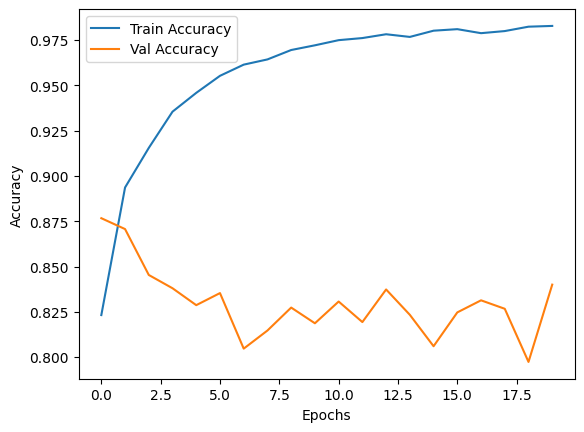

In [18]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 

plt.legend(['Train Accuracy', 'Val Accuracy']) 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")

plt.show()

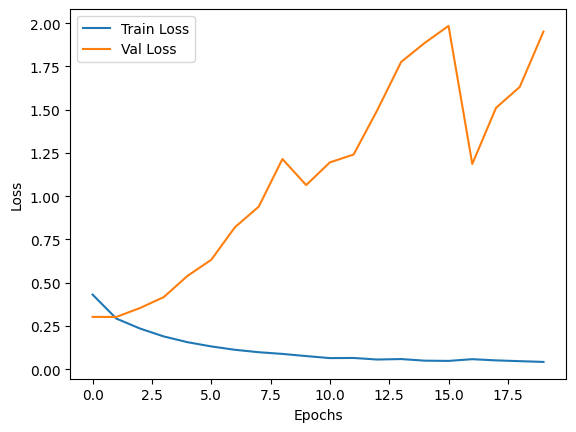

In [19]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 

plt.legend(['Train Loss', 'Val Loss']) 
plt.xlabel("Epochs") 
plt.ylabel("Loss")

plt.show()

In [28]:
vocab = vectorization_layer.get_vocabulary()

#Create a mapping from indices to tokens
index_to_token = {index: token for index, token in enumerate(vocab)}



def decode_prediction(sentence):
    sent = np.array(sentence) 
    new_sent = ""
    
    for i in range(len(sent)):
        if sent[i] in index_to_token:
             new_sent += index_to_token[sent[i]] + " " 
                
    return new_sent
                


In [21]:
predictions = model.predict(x_sentences)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


In [35]:
preds = tf.math.sigmoid(predictions) 
preds = np.array(preds).reshape(-1) 

n = 10 

for i in range(n):
    pred = preds[i] 
    
    if pred <=0.5: 
        pred = 0 
    else:
        pred = 1 
        
    sent = decode_prediction(x_sentences[i]) 
    print("Actual : ", int(x_labels[i]))
    print("Prediction : ", pred) 
    print(sent)
    
    print("\n\n")
    

Actual :  0
Prediction :  0
[UNK] কিছু কোনো টেনশন নাই দালাল গুলে এত টেনশন কেন           



Actual :  0
Prediction :  0
[UNK] মতো পাপনের পেটা ফুলে [UNK] দুর্নীতি আল্লাহ সয্য [UNK] না।।।।          



Actual :  0
Prediction :  0
পাপন কে বিসিবি থেকে বাদ দেয়া হুক কারন সে নিজের [UNK] [UNK] বুজে        



Actual :  1
Prediction :  1
এই মাগির সম্পূর্ণ ভুয়া খবর ওই ম তোর বাসা কোথায়           



Actual :  0
Prediction :  0
সঠিক বিচার চাই                  



Actual :  0
Prediction :  0
বুড়া এখনো বেচে আছে                 



Actual :  0
Prediction :  0
ভাই আমি এক জন [UNK] [UNK] আসাম [UNK] পুর আমার বাড়ি [UNK] কাহিনী খুব ভাল লাগছে আমিন [UNK] বিচার চাই 



Actual :  0
Prediction :  0
অনেক অনেক ভালো লাগলো                 



Actual :  0
Prediction :  0
এটা ইন্ডিয়ার একটা ছাল                 



Actual :  1
Prediction :  1
জানোয়ারটাকে রাসতার উপর ফাসি দেওয়াহোক যেন তাকে দেখে আর কোন জানোয়ার যেন এমন কাজ করতে না পারে    



